# Classifying elliptic curves by complex multiplication

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm.notebook import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("output/dataset.csv")

In [3]:
df.head()

,A2,A3,A5,A7,A11,A13,A17,A19,A23,A29,...,A9901,A9907,A9923,A9929,A9931,A9941,A9949,A9967,A9973,CM
0,0.000000,0.577350,0.000000,0.000000,0.000000,-0.27735,0.000000,0.917663,1.668115,1.114172,...,0.532643,0.934355,0.331278,-0.541927,1.264370,-1.384089,-0.421075,-1.302150,-1.862516,0.0
1,0.707107,0.000000,0.447214,1.511858,0.000000,-1.10940,1.455214,-0.688247,-0.208514,0.000000,...,1.507481,1.547211,-1.264879,0.311106,1.314543,0.702074,1.584044,0.220364,1.361840,0.0
2,-0.707107,0.000000,-0.447214,0.000000,1.206045,-1.10940,-1.455214,0.458831,0.000000,1.856953,...,-1.286383,-0.874074,0.301162,-1.384925,-0.200694,0.140415,-1.142918,-0.030050,0.961299,0.0
3,0.000000,-1.154701,0.000000,-1.511858,-0.904534,0.55470,0.000000,0.458831,1.251086,-1.671258,...,-0.311546,1.587399,-1.415460,1.384925,-0.762636,-0.300889,1.193046,1.041720,-1.061434,0.0
4,-1.414214,0.000000,0.000000,1.133893,0.000000,-0.55470,0.727607,0.917663,0.000000,-0.928477,...,-0.693441,-0.170796,0.582246,0.511820,0.070243,-0.742193,1.162969,0.130215,1.061434,0.0


In [4]:
X = np.array(df)
X = np.delete(X, len(X[0])-1, 1)
Y = np.array(df["CM"])

In [5]:
X.shape

(5000, 1229)

In [6]:
Y.shape

(5000,)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

## Neural network model

In [8]:
DATA_SIZE = len(X[0])
N_EPOCHS = 1000
SAMPLE_SIZE = 100
model = nn.Sequential(
        nn.Linear(DATA_SIZE, DATA_SIZE//2),
        nn.Tanh(),
        nn.Linear(DATA_SIZE//2, DATA_SIZE//4),
        nn.Tanh(),
        nn.Dropout(0.1),
        nn.Linear(DATA_SIZE//4, DATA_SIZE//8),
        nn.Tanh(),
        nn.Linear(DATA_SIZE//8, 2),
        nn.Softmax()
)
criterion = nn.CrossEntropyLoss() # The MOST inconvinient criterion ever!
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
losses = []
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for i in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[i])
        target = torch.Tensor([int(sample_y[i])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output.reshape((1,2)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    losses.append(avg_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


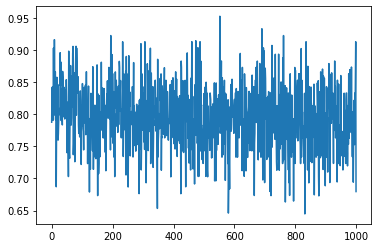

In [10]:
plt.plot(losses)
plt.show()

In [11]:
x=torch.tensor(X_train[50], dtype=torch.double).float()

In [12]:
err_cnt = 0
correct_cnt = 0
for i in tnrange(len(X_test)):
    x = torch.tensor(X_test[i], dtype=torch.double).float()
    y = Y_test[i]
    _y = model(x)
    if round(y) != round(float(_y[0])):
        err_cnt+=1
    else:
        correct_cnt+=1
print("Acc: %.3f"%(correct_cnt/(correct_cnt+err_cnt)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Acc: 0.529


As it can be seen neural network are absolutely useless for classifying _~~anything~~_ elliptic curves.